<a href="https://colab.research.google.com/gist/darwinyusef/2b6a5358de792346e836558d45ba8e2e/detr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DETR in `transformers`
In this notebook, we going through a simple example of using pretrained `detr-resnet-50` to detect some objects in an image.

In [20]:
%pip install timm

In [21]:
# this example is mainly from https://huggingface.co/facebook/detr-resnet-50

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw
import requests

In [28]:
url = "https://i.ytimg.com/vi/QeWPWyBH2Ko/maxresdefault.jpg"
image = Image.open(requests.get(url, stream=True).raw)

### Model
We are using `facebook/detr-resnet-50`, which is a basic DETR with a relatively small ResNet backbone. It has 100 object queries, which mean it can detect a maximum of 100 objects.

In [29]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Processor
The processor converts the image into a dict with keys `pixel_values` and `pixel_mask`. The pixel values are usually transformed in a manner that matches the paper implementation, which may involve normalization, resizing, etc.

In [30]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
inputs = processor(images=image, return_tensors="pt")

### Outputs
The output of the model is of type `DetrObjectDetectionOutput`, which contains `logits`, `last_hidden_states`, `pred_boxes`, etc. <br>
The size of `logits` is `(batch size, n_object_queries, n_classes)`, which is used to determine the classes of the detections. This model has 100 object queries and 92 classes. The object queries that have low confidences in classes, or have a "no object" class are filtered out in the `post_process_object_detection` function. <br>
The size of `pred_boxes` is `(batch size, n_object_queries, box_dimensions)`, which is used to determine the location of the bounding box.

In [31]:
outputs = model(**inputs)

In [32]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected book with confidence 0.953 at location [129.27, 310.69, 195.71, 547.72]
Detected keyboard with confidence 0.999 at location [260.48, 627.34, 759.78, 709.22]
Detected potted plant with confidence 0.937 at location [0.21, 320.87, 93.99, 541.79]
Detected book with confidence 0.978 at location [78.31, 298.3, 157.64, 550.3]
Detected book with confidence 0.937 at location [125.07, 321.01, 179.25, 548.22]
Detected mouse with confidence 0.999 at location [805.67, 606.85, 914.48, 710.42]
Detected laptop with confidence 0.997 at location [886.16, 65.45, 1280.49, 574.56]


In [33]:
img_draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    img_draw.rectangle(((box[0], box[1]),(box[2], box[3])), outline='Red')
    img_draw.text((box[0], box[1]), model.config.id2label[label.item()], align ="left")

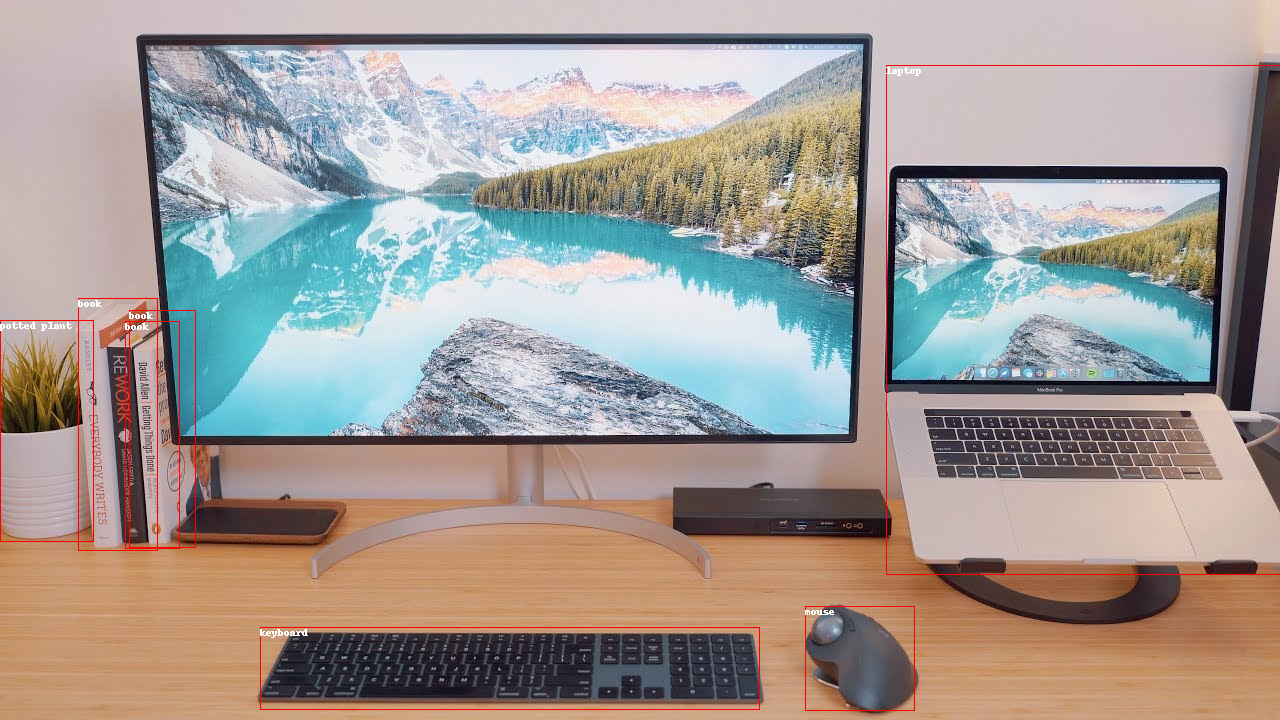

In [34]:
display(image)